## Import

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Optional, Union
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import sys 

sys.path.append('../../modules')
import eumf_data
import eumf_pipeline
import eumf_eval
from eumf_data import Labeled

from sklearn import preprocessing, pipeline, compose, ensemble, model_selection, metrics, impute

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)



## Load Data

### Migration and Google data

In [2]:
# migration rates
values = eumf_data.load_migration_rates_from_csv()

# google trends
trends = eumf_data.load_trends_from_csv()

countries = eumf_data.get_countries()
keyword_ids = trends.columns.levels[0].tolist()


### Macroeconomic data

In [3]:
df_gdp = eumf_data.read_gdp()
df_unempl = eumf_data.read_unempl()

df_gdp.head()


gdp                                                                                                                                                             
country      AT    BE   BG    CH     CY    CZ    DK    EE    ES    FI    FR    GB    GR    HR    HU    IE    IT    LT    LU     LV    NL    PL    PT   RO    SE    SI    SK 
2004-03-31  7000  6860  570  10550  4530  2090  8970  1690  4790  7050  6730  7980  4100  1760  1810  9410  5880  1160  14680  1140  7960  1170  3430  500  8280  3170  1460
2004-06-30  7370  7170  640  10990  4700  2330  9340  1750  5080  7590  6790  8110  4350  1960  2100  9710  6320  1330  15230  1290  8210  1260  3640  630  8770  3510  1560
2004-09-30  7490  6950  760  10980  4900  2420  9280  1830  4900  7550  6660  8200  4640  2130  2120  9400  6130  1410  14940  1360  7920  1360  3650  780  8310  3550  1680
2004-12-31  7810  7500  750  11360  5020  2630  9870  1880  5280  8180  6990  8070  4600  1920  2270  9870  6770  1490  16070  1380  8410  1630  3800  900  9140  3630  1760
2005-03-31  7240  7110  640  10850  4810  2470  9250  1860  5070  7430  6900  8180  4170  1870  1970  9970  6000  1320  15170  1290  8200  1500  3560  690  8520  3270  1670

## Preprocessing

### Imputation

In [4]:
imputer = impute.KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(values.to_numpy())
values_imputed = pd.DataFrame(imputed, index=values.index, columns=values.columns)

panel = values_imputed.join(trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_3m["2010":"2010"]


value                                                                                                                                                                                                                                                       10                                                                                                                                     ...  59                                                                                                                                60                                                                                                                                                                                 
country        AT       BE        BG       CH       CY      CZ       DK       EE        ES       FI        FR        GB        GR       HR        HU       IE        IT       LT       LU       LV       NL        PL        PT        RO       SE       SI       SK     AT   BE   BG    CH    CY   CZ   DK   EE     ES    FI     FR      GB    GR   HR   HU   IE     IT    LT   LU   LV     NL      PL    PT   ...  CY   CZ   DK   EE     ES    FI     FR      GB    GR   HR   HU   IE    IT    LT   LU   LV    NL    PL   PT   RO   SE   SI   SK     AT      BE      BG      CH    CY     CZ      DK    EE     ES    FI     FR      GB    GR   HR   HU     IE      IT    LT   LU   LV     NL      PL      PT      RO      SE    SI   SK 
date                                                                                                                                                                                                                                                                                                                                                                                                            ...                                                                                                                                                                                                                                                                                                                       
2010-03-31   862.667  216.333  2747.333  368.000  13.667  445.333  180.333   75.667   845.000  144.000  1012.000   692.667   790.000  704.333  1970.667   95.000  1976.000  430.333  148.333  560.667  726.667   7632.000  526.333  4353.000  202.333  144.333  568.667  0.0  0.0  0.0  2.238  0.0  0.0  0.0  0.0  18.429  0.0  19.619  15.762  0.0  0.0  0.0  0.0   8.762  0.0  0.0  0.0  16.667   5.190  0.0  ...  0.0  0.0  0.0  0.0  15.571  0.0  17.048   7.143  0.0  0.0  0.0  0.0  3.714  0.0  0.0  0.0  6.619  0.0  0.0  0.0  0.0  0.0  0.0  18.810   9.095  10.524  21.857  0.0   7.143   5.429  0.0  27.762  0.0  18.381  39.238  0.0  0.0  0.0   3.476   9.857  0.0  0.0  0.0   3.095  11.714  23.238   9.952  17.333  0.0  0.0
2010-06-30   811.667  195.667  3117.667  345.667  10.000  565.667  131.333   81.333   777.667  111.000   916.667   673.000   816.333  910.000  2459.000   98.000  1811.000  515.333  151.667  605.667  742.333  12445.667  511.667  7643.000  163.667  123.667  826.000  0.0  0.0  0.0  7.381  0.0  0.0  0.0  0.0  19.429  0.0   9.286  33.143  0.0  0.0  0.0  0.0   5.619  0.0  0.0  0.0  28.000   9.810  0.0  ...  0.0  0.0  0.0  0.0   8.095  0.0  12.857  29.048  0.0  0.0  0.0  0.0  1.381  0.0  0.0  0.0  2.333  0.0  0.0  0.0  0.0  0.0  0.0  15.238  13.143   0.000  27.286  0.0  11.238   6.571  0.0  27.714  0.0  19.190  50.524  0.0  0.0  0.0  25.143  27.857  0.0  0.0  0.0  31.714  18.095  12.238  10.476  25.143  0.0  0.0
2010-09-30  1168.667  323.000  3891.000  527.333  33.333  618.667  286.000  125.667  1556.333  237.667  1532.333  1209.000  1186.000  944.667  2970.333  173.667  2195.000  617.000  241.000  806.333  925.667  10549.333  645.000  7125.000  290.000  161.000  864.667  0.0  0.0  0.0  6.952  0.0  0.0  0.0  0.0  18.857  0.0  13.905  18.429  0.0  0.0  0.0  0.0   1.714  0.0  0.0  0.0   7.714  11.381  0.0  ...  0.0  0.0  0.0  0.0  23.381  0.0  

### Combine countries, join macroeconomic data

In [5]:
panel_comb = eumf_data.combine_countries(panel)
panel_comb_3m = eumf_data.combine_countries(panel_3m)
df_gdp_comb = eumf_data.combine_countries(df_gdp)
df_unempl_comb = eumf_data.combine_countries(df_unempl, average=True)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


10                                                                                                                                   11                                                                                                                                                           112                                                                              ...   value                                                                                             gdp                                                                                                                                                                   unempl                                                                                                              
country     AT  BE+NL+LU  BG     CH   CZ+SK  DK     ES      FR      GB   GR+CY  HR   HU   IE     IT   LV+LT+EE    PL    PT   RO   SE+FI   SI     AT   BE+NL+LU    BG      CH    CZ+SK     DK      ES      FR      GB    GR+CY    HR      HU      IE      IT   LV+LT+EE    PL      PT      RO    SE+FI   SI     AT   BE+NL+LU    BG      CH    CZ+SK      DK      ES      FR      GB    GR+CY   ...     HR        HU       IE        IT     LV+LT+EE     PL        PT        RO      SE+FI      SI       AT    BE+NL+LU    BG      CH     CZ+SK     DK       ES      FR      GB    GR+CY      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO    SE+FI      SI     AT   BE+NL+LU  BG   CH  CZ+SK  DK    ES   FR   GB  GR+CY    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI  SI 
date                                                                                                                                                                                                                                                                                                                                                                                           ...                                                                                                                                                                                                                                                                                                                                                                                               
2017-03-31  0.0  16.048   0.0  10.524   0.0  0.0  26.667  21.857  21.381   0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286  0.0  15.333  60.190    2.190  19.381  10.857  17.762  38.714  29.810  53.381  12.810  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571   8.762  0.0  66.238  178.952  42.238  30.952  127.048  55.571  33.143  63.333  47.286  29.619  ...  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  456.333  420.333  10080.0  42970.0  1510.0  18700.0  7620.0  12410.0  5950.0  8450.0  9080.0   9270.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  21370.0  4790.0   5.7    6.433   6.6  0.0  6.00  6.0  18.2  9.6  4.6  17.35  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3  7.75  7.4
2017-06-30  0.0  14.810   0.0   4.952   0.0  0.0  21.048  13.952  18.857   0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714  0.0  16.619  61.619   10.619  22.667   7.714  22.286  24.381  27.952  55.714   8.286  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  10.571  0.0  58.048  168.905  35.190  27.571   83.429  62.952  23.810  57.857  48.000  36.476  ...  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  367.000  365.000  10480.0  44540.0  1800.0  18770.0  8470.0  13040.0  6330.0  8560.0  8980.0  10000.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  22550.0  5260.0   5.4    5.867   6.2  0.0  5.75  5.9  17.3  9.6  4.4  16.70  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9  7.75  6.6
2017-09-30  0.0  16.095   0.0   4.905   0.0  0.0  12.429  21.048  16.048   0.0  0.0  0.0  0.0  11.810    0.0    10.762  0.0  0.0   9.667  0.0  19.143  68.952   16

## Experiments

### Common definitions

In [7]:
cv_default = model_selection.KFold(n_splits=6, shuffle=False)
cv_stratified = model_selection.KFold(n_splits=6, shuffle=True, random_state=42)

# LabeledTuple = tuple[Labeled, Labeled]


# def prepare_data(
#     panel: pd.DataFrame,
#     columns: list = ["19"],
#     lags=[1, 2, 3, 4],
#     t_min="2011",
#     t_max="2019",
# ) -> Labeled:

#     panel_lags = eumf_data.create_lags(panel, lags=lags, columns=columns).fillna(0.0)

#     # define x, y; set minimum value
#     x = panel_lags.applymap(lambda x: max(x, 0.1))
#     y = panel["value"]

#     return Labeled(x, y)[t_min:t_max]


# def transform_data(data_in: Labeled, delta=4) -> Labeled:
#     # transformation: logdiff

#     x = np.log(data_in.x) - np.log(data_in.x.shift(delta))
#     y = np.log(data_in.y) - np.log(data_in.y.shift(delta))

#     return Labeled(x.iloc[delta:], y.iloc[delta:])


# def split_data(
#     data_in: Labeled, t_test_min="2018-01-01", t_test_max="2019-12-01",
# ) -> LabeledTuple:

#     # t_min = "2012-01-01"
#     # t_max = "2019-12-01"
#     # t_split_lower = "2017-12-01"
#     # t_split_upper = "2018-01-01"

#     # train = data_in[t_min:t_split_lower]
#     # test = data_in[t_split_upper:t_max]

#     test = data_in[t_test_min:t_test_max]
#     train = Labeled(data_in.x.drop(test.index), data_in.y.drop(test.index))
#     # train = data_in.apply(lambda df: df.drop(test.index))

#     return train, test


# def stack_data(
#     train: Labeled, test: Optional[Labeled] = None
# ) -> Union[LabeledTuple, Labeled]:
#     # stacking
#     if test is None:
#         train = eumf_data.stack_labeled(train)
#         return train
#     else:
#         train = eumf_data.stack_labeled(train)
#         test = eumf_data.stack_labeled(test)
#         return train, test


# def discretize_labels(
#     train: Labeled, test: Optional[Labeled] = None, bins=None, classes=None
# ) -> Union[LabeledTuple, Labeled]:
#     # Note: bins must be set

#     train = train.copy()
#     train.y = pd.cut(train.y, bins, labels=classes)

#     if test is None:
#         return train
#     else:
#         test = test.copy()
#         test.y = pd.cut(test.y, bins, labels=classes)

#         return train, test


# def train_cls_model(
#     train: Labeled, cls=None, ct=None, cv=cv_default, params={}, scoring="f1_macro",
# ) -> model_selection.GridSearchCV:

#     if ct is None:
#         ct = compose.make_column_transformer(
#             (preprocessing.OneHotEncoder(), ["country"]),
#             remainder="passthrough",
#             sparse_threshold=0,
#             verbose_feature_names_out=False,
#         )

#     if cls is None:
#         cls = ensemble.RandomForestClassifier(random_state=1)

#     model = pipeline.make_pipeline(ct, cls)

#     hptuner = model_selection.GridSearchCV(
#         model, params, cv=cv, scoring=scoring, n_jobs=-1,
#     )
#     hptuner.fit(train.x, train.y)

#     return hptuner



### Multiclass variant

#### Obtain optimum discretization

In [9]:
cv_scores = {}

for delta1 in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    for delta2 in [0.0, 0.5, 0.7, 1.0]:

        if delta2 == 0.0:
            bins = [-np.inf, np.log(1.0 - delta1), np.log(1.0 + delta1), np.inf]
            classes = ["-", "=", "+"]
        else:
            bins = [
                -np.inf,
                np.log(1.0 - delta1),
                np.log(1.0 + delta1),
                np.log(1.0 + delta2),
                np.inf,
            ]
            classes = ["-", "=", "+", "++"]

        labeled = eumf_pipeline.prepare_data(
            panel_comb_3m_macro, columns=["19", "value", "gdp", "unempl"]
        )
        transformed = eumf_pipeline.transform_data(labeled)
        train, test = eumf_pipeline.split_data(transformed, t_test_max="2014", t_test_min="2014")
        train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
        train_cls, test_cls = eumf_pipeline.discretize_labels(
            train_stacked, test_stacked, bins=bins, classes=classes
        )

        tuner = eumf_pipeline.train_cls_model(train_cls)

        cv_scores[(delta1, delta2)] = eumf_eval.score_cv(
            tuner.best_estimator_,
            train_cls.x,
            train_cls.y,
            cv=cv_default,
            scoring=["f1_micro", "f1_macro"],
        )


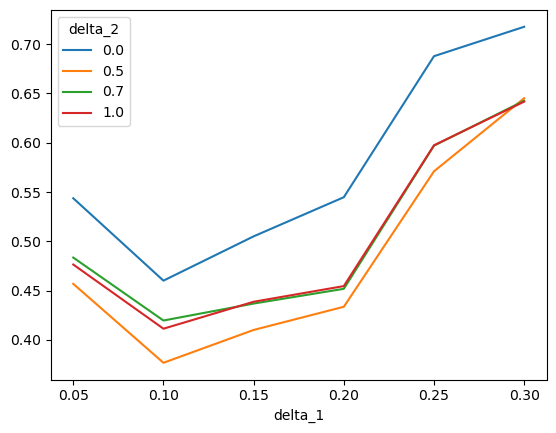

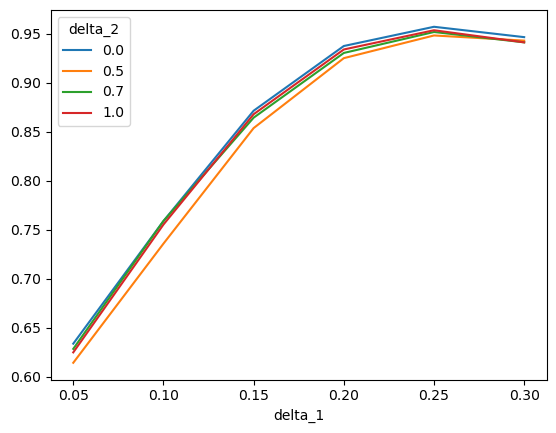

In [10]:
results = (
    pd.concat({k: v for k, v in cv_scores.items()})
    .rename_axis(index=["delta_1", "delta_2", "fold"])
    .groupby(level=[0, 1])
    .mean()
)
results.unstack(level=1)["test_f1_macro"].plot()
plt.show()
results.unstack(level=1)["test_f1_micro"].plot()
plt.show()

# ["test_f1_macro"].plot()
# plt.show()


Despite these results, one should opt for lower thresholds. Otherwise, number of class members is too small and meaningless.

#### Common definitions

In [11]:
SCORING_MULTICLS = ["f1_micro", "f1_macro", "precision_macro", "recall_macro"]
T_TEST_MIN_MULTICLS = "2014"
T_TEST_MAX_MULTICLS = "2014"


#### 4 Classes: Best configuration

In [12]:
"""training"""

bins = [-np.inf, np.log(0.95), np.log(1.05), np.log(1.5), np.inf]
classes = ["-", "=", "+", "++"]

params = {}

labeled = eumf_pipeline.prepare_data(panel_comb_3m_macro, columns=["19", "value", "gdp", "unempl"])
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN_MULTICLS, t_test_max=T_TEST_MAX_MULTICLS
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=bins, classes=classes
)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params)

display(pd.DataFrame(tuner.cv_results_))

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_,
    train_cls.x,
    train_cls.y,
    cv=cv_default,
    scoring=SCORING_MULTICLS,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls.x, test_cls.y, scoring=SCORING_MULTICLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.266,0.016,0.027,0.007,{},0.367,0.483,0.453,0.407,0.522,0.509,0.457,0.055,1


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Aggregate CV score:


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,mean,std,sem
fit_time,0.166,0.014,0.006
score_time,0.020,0.006,0.002
test_f1_micro,0.614,0.036,0.015
test_f1_macro,0.457,0.060,0.025
test_precision_macro,0.510,0.062,0.025
test_recall_macro,0.464,0.073,0.030


Individual CV scores:


,fit_time,score_time,test_f1_micro,test_f1_macro,test_precision_macro,test_recall_macro
0,0.174,0.018,0.606,0.367,0.556,0.360
1,0.149,0.016,0.681,0.483,0.490,0.488
2,0.175,0.019,0.602,0.453,0.470,0.450
3,0.153,0.016,0.581,0.407,0.414,0.416
4,0.186,0.019,0.624,0.522,0.551,0.572
5,0.160,0.031,0.591,0.509,0.577,0.500


Holdout score:


f1_micro           0.600
f1_macro           0.474
precision_macro    0.498
recall_macro       0.466
dtype: float64

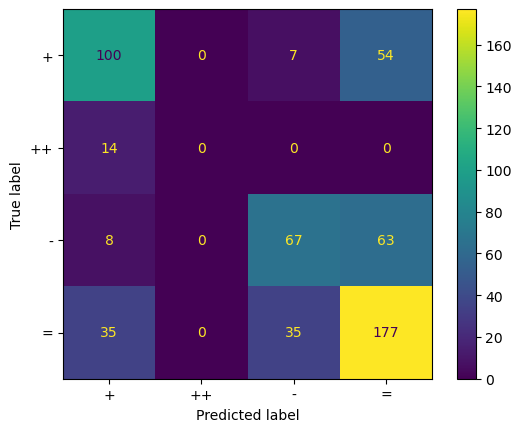

In [13]:
"""confusion matrix"""

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_default
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv)
plt.show()


Category ++ never recognized. Categories + and - only in two thirds/half of the cases. Not acceptable.

#### 3 Classes: Best Configuration

In [14]:
bins = [-np.inf, np.log(0.95), np.log(1.05), np.inf]
classes = ["-", "=", "+"]

params = {}

labeled = eumf_pipeline.prepare_data(panel_comb_3m_macro, columns=["19", "value", "gdp", "unempl"])
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN_MULTICLS, t_test_max=T_TEST_MAX_MULTICLS
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=bins, classes=classes
)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params)

display(pd.DataFrame(tuner.cv_results_))

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_,
    train_cls.x,
    train_cls.y,
    cv=cv_default,
    scoring=SCORING_MULTICLS,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls.x, test_cls.y, scoring=SCORING_MULTICLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.294,0.081,0.025,0.005,{},0.515,0.647,0.612,0.492,0.554,0.442,0.544,0.07,1


Aggregate CV score:


,mean,std,sem
fit_time,0.153,0.030,1.205e-02
score_time,0.016,0.001,5.296e-04
test_f1_micro,0.634,0.059,2.402e-02
test_f1_macro,0.544,0.077,3.131e-02
test_precision_macro,0.637,0.098,4.012e-02
test_recall_macro,0.540,0.082,3.343e-02


Individual CV scores:


,fit_time,score_time,test_f1_micro,test_f1_macro,test_precision_macro,test_recall_macro
0,0.210,0.018,0.713,0.515,0.802,0.478
1,0.157,0.015,0.681,0.647,0.693,0.642
2,0.131,0.016,0.613,0.612,0.636,0.601
3,0.134,0.017,0.602,0.492,0.587,0.480
4,0.137,0.015,0.645,0.554,0.582,0.594
5,0.146,0.017,0.548,0.442,0.525,0.444


Holdout score:


f1_micro           0.637
f1_macro           0.635
precision_macro    0.692
recall_macro       0.612
dtype: float64

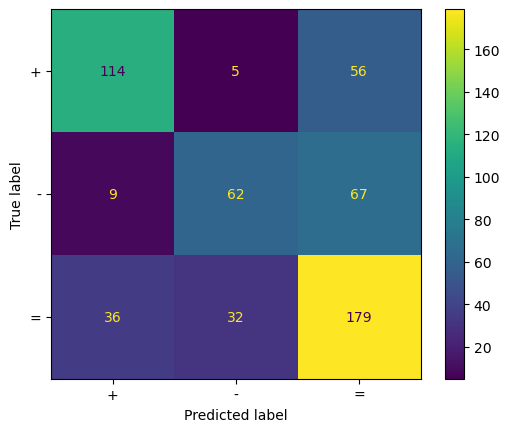

In [15]:
# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_default
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv)
plt.show()


Same results as above, only with garbage class ++ missing. Still not acceptable for forecast.

### Binary variant (a.k.a. "early warning system")

Due to the unsatisfactory results above, it might be an option to offer a pure excess forecasting model instead with only two classes. It does not seem wise to include autoregressive lags in such a model because it could introduce too much reliance on past values which should be avoided for early warning systems. However, it makes sense to test that

#### Optimum threshold

In [17]:
### TRAINING

thresholds = [1.05, 1.1, 1.15, 1.20, 1.25, 1.3, 1.35, 1.4]
scores = []

for thresh in thresholds:

    bins = [-np.inf, np.log(thresh), np.inf]
    classes = [0, 1]

    params = {}

    labeled = eumf_pipeline.prepare_data(panel_comb_3m_macro, columns=["19", "gdp", "unempl"])
    transformed = eumf_pipeline.transform_data(labeled)

    # stacked = stack_data(transformed)
    # data_cls = discretize_labels(stacked)

    train, test = eumf_pipeline.split_data(transformed, t_test_min="2014", t_test_max="2014")
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
    train_cls, test_cls = eumf_pipeline.discretize_labels(
        train_stacked, test_stacked, bins=bins, classes=classes
    )

    # train_stacked = stack_data(transformed)
    # train_cls = discretize_labels(train_stacked, bins=bins, classes=classes)

    tuner = eumf_pipeline.train_cls_model(train_cls, params=params, cv=cv_stratified, scoring="f1")

    scores.append(
        eumf_eval.score_cv(
            tuner.best_estimator_,
            train_cls.x,
            train_cls.y,
            cv=cv_stratified,
            scoring=["precision", "recall", "f1"],
        )
    )



/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


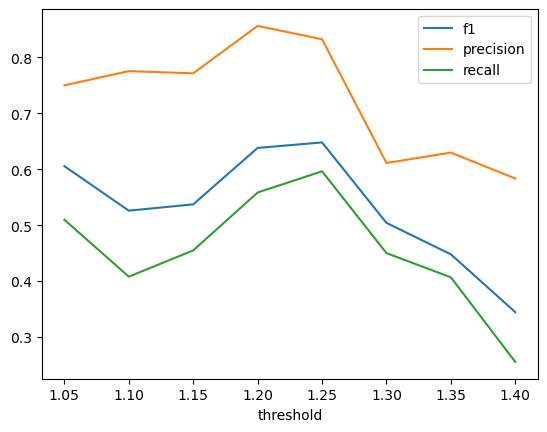

In [18]:
### PLOT

scores_df = (
    pd.concat([s.mean() for s in scores], axis=1)
    .transpose()
    .assign(threshold=thresholds)
)
plt.plot(scores_df["threshold"], scores_df["test_f1"], label="f1")
plt.plot(scores_df["threshold"], scores_df["test_precision"], label="precision")
plt.plot(scores_df["threshold"], scores_df["test_recall"], label="recall")
plt.xlabel("threshold")
plt.legend()
plt.show()


Either 1.2 or 1.25 are viable choices for a threshold. Problem with very low (1.05) would be more positive cases and thus a higher requirement regarding recall to be useful.

#### Common definitions

In [19]:
SCORING_TWOCLS = [
    "roc_auc",
    "average_precision",
    "f1",
    "precision",
    "recall",
    "f1_macro",
]
# note: f1 macro only for comparison

T_TEST_MIN_TWOCLS = "2014"
T_TEST_MAX_TWOCLS = "2014"

BINS_TWOCLS = [-np.inf, np.log(1.20), np.inf]


#### Best configuration (without autoregression)

In [20]:
### TRAINING

params = {}

labeled = eumf_pipeline.prepare_data(panel_comb_3m_macro, columns=["19", "unempl", "gdp"])
transformed = eumf_pipeline.transform_data(labeled)

# stacked = stack_data(transformed)
# data_cls = discretize_labels(stacked)

train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN_TWOCLS, t_test_max=T_TEST_MAX_TWOCLS
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=BINS_TWOCLS, classes=[0, 1]
)

# train_stacked = stack_data(transformed)
# train_cls = discretize_labels(train_stacked, bins=bins, classes=classes)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params, cv=cv_stratified)

display(pd.DataFrame(tuner.cv_results_))


cv_score = eumf_eval.score_cv(
    tuner.best_estimator_,
    train_cls.x,
    train_cls.y,
    cv=cv_stratified,
    scoring=SCORING_TWOCLS,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls.x, test_cls.y, scoring=SCORING_TWOCLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.269,0.008,0.022,0.002,{},0.812,0.838,0.815,0.942,0.683,0.739,0.805,0.081,1


Aggregate CV score:


,mean,std,sem
fit_time,0.130,0.029,0.012
score_time,0.026,0.003,0.001
test_roc_auc,0.949,0.049,0.020
test_average_precision,0.753,0.142,0.058
test_f1,0.638,0.170,0.069
test_precision,0.856,0.163,0.067
test_recall,0.558,0.218,0.089
test_f1_macro,0.805,0.089,0.036


Individual CV scores:


,fit_time,score_time,test_roc_auc,test_average_precision,test_f1,test_precision,test_recall,test_f1_macro
0,0.185,0.030,0.943,0.743,0.667,0.636,0.700,0.812
1,0.109,0.023,0.958,0.768,0.706,0.750,0.667,0.838
2,0.136,0.030,0.958,0.768,0.667,0.750,0.600,0.815
3,0.126,0.024,0.997,0.943,0.889,1.000,0.800,0.942
4,0.115,0.023,0.857,0.503,0.400,1.000,0.250,0.683
5,0.111,0.027,0.980,0.795,0.500,1.000,0.333,0.739


Holdout score:


roc_auc              0.769
average_precision    0.596
f1                   0.444
precision            1.000
recall               0.286
f1_macro             0.687
dtype: float64

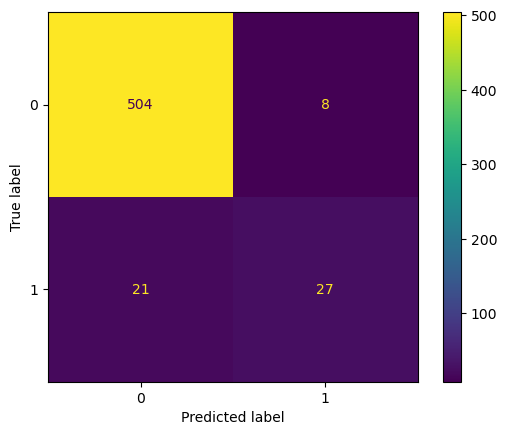

In [21]:
### CONFUSION MATRIX

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_stratified
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv)
plt.show()


In [22]:
### FEATURE IMPORTANCE

# pd.Series(reg.steps[-1][1].feature_importances_[-8:], index=x_train_stacked.columns[1:])
estimator = tuner.best_estimator_

features_names_out = estimator.steps[0][1].get_feature_names_out()
pd.Series(
    estimator.steps[-1][1].feature_importances_, index=features_names_out
).sort_values(ascending=False)



19_1                1.434e-01
19_3                9.981e-02
unempl_1            9.787e-02
unempl_2            9.704e-02
19_2                9.479e-02
unempl_4            6.958e-02
19_4                6.745e-02
gdp_1               6.223e-02
unempl_3            5.758e-02
gdp_2               5.591e-02
gdp_4               4.527e-02
gdp_3               4.226e-02
country_HR          1.417e-02
country_RO          1.018e-02
country_ES          9.788e-03
country_SI          4.474e-03
country_IT          4.416e-03
country_GB          3.727e-03
country_IE          2.996e-03
country_PT          2.525e-03
country_GR+CY       2.301e-03
country_HU          2.268e-03
country_AT          1.784e-03
country_PL          1.484e-03
country_CZ+SK       1.355e-03
country_BG          1.119e-03
country_BE+NL+LU    1.115e-03
country_CH          1.088e-03
country_DK          7.876e-04
country_FR          4.536e-04
country_SE+FI       4.023e-04
country_LV+LT+EE    3.759e-04
dtype: float64

#### GT only

In [23]:
### TRAINING

params = {}

labeled = eumf_pipeline.prepare_data(panel_comb_3m_macro, columns=["19"])
transformed = eumf_pipeline.transform_data(labeled)

# stacked = stack_data(transformed)
# data_cls = discretize_labels(stacked)

train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN_TWOCLS, t_test_max=T_TEST_MAX_TWOCLS
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=BINS_TWOCLS, classes=[0, 1]
)

# train_stacked = stack_data(transformed)
# train_cls = discretize_labels(train_stacked, bins=bins, classes=classes)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params, cv=cv_stratified)

display(pd.DataFrame(tuner.cv_results_))


cv_score = eumf_eval.score_cv(
    tuner.best_estimator_,
    train_cls.x,
    train_cls.y,
    cv=cv_stratified,
    scoring=SCORING_TWOCLS,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls.x, test_cls.y, scoring=SCORING_TWOCLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.271,0.006,0.025,0.002,{},0.816,0.863,0.795,0.777,0.758,0.708,0.786,0.048,1


Aggregate CV score:


,mean,std,sem
fit_time,0.129,0.042,0.017
score_time,0.030,0.006,0.002
test_roc_auc,0.906,0.047,0.019
test_average_precision,0.720,0.087,0.036
test_f1,0.600,0.105,0.043
test_precision,0.851,0.133,0.054
test_recall,0.479,0.133,0.054
test_f1_macro,0.786,0.053,0.021


Individual CV scores:


,fit_time,score_time,test_roc_auc,test_average_precision,test_f1,test_precision,test_recall,test_f1_macro
0,0.149,0.033,0.852,0.674,0.667,0.750,0.600,0.816
1,0.126,0.039,0.908,0.829,0.750,0.857,0.667,0.863
2,0.204,0.030,0.883,0.631,0.625,0.833,0.500,0.795
3,0.097,0.025,0.984,0.825,0.571,1.000,0.400,0.777
4,0.098,0.025,0.876,0.712,0.545,1.000,0.375,0.758
5,0.099,0.027,0.935,0.651,0.444,0.667,0.333,0.708


Holdout score:


roc_auc              0.629
average_precision    0.517
f1                   0.455
precision            0.625
recall               0.357
f1_macro             0.684
dtype: float64

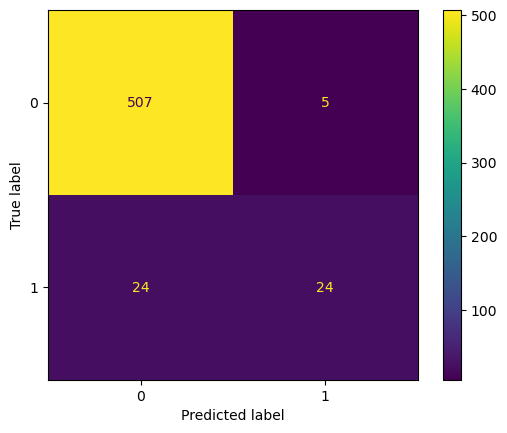

In [24]:
### CONFUSION MATRIX

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_stratified
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv)
plt.show()


#### Macroeconomic only

In [25]:
### TRAINING

params = {}

labeled = eumf_pipeline.prepare_data(panel_comb_3m_macro, columns=["gdp", "unempl"])
transformed = eumf_pipeline.transform_data(labeled)

# stacked = stack_data(transformed)
# data_cls = discretize_labels(stacked)

train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN_TWOCLS, t_test_max=T_TEST_MAX_TWOCLS
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=BINS_TWOCLS, classes=[0, 1]
)

# train_stacked = stack_data(transformed)
# train_cls = discretize_labels(train_stacked, bins=bins, classes=classes)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params, cv=cv_stratified)

display(pd.DataFrame(tuner.cv_results_))


cv_score = eumf_eval.score_cv(
    tuner.best_estimator_,
    train_cls.x,
    train_cls.y,
    cv=cv_stratified,
    scoring=SCORING_TWOCLS,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls.x, test_cls.y, scoring=SCORING_TWOCLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.259,0.003,0.021,0.002,{},0.693,0.768,0.888,0.825,0.591,0.825,0.765,0.098,1


Aggregate CV score:


,mean,std,sem
fit_time,0.151,0.045,0.018
score_time,0.032,0.003,0.001
test_roc_auc,0.893,0.161,0.066
test_average_precision,0.666,0.187,0.076
test_f1,0.562,0.204,0.083
test_precision,0.808,0.186,0.076
test_recall,0.478,0.224,0.091
test_f1_macro,0.765,0.107,0.044


Individual CV scores:


,fit_time,score_time,test_roc_auc,test_average_precision,test_f1,test_precision,test_recall,test_f1_macro
0,0.230,0.031,0.930,0.571,0.444,0.50,0.400,0.693
1,0.117,0.038,0.935,0.688,0.571,0.80,0.444,0.768
2,0.176,0.033,0.969,0.820,0.800,0.80,0.800,0.888
3,0.116,0.029,0.988,0.839,0.667,0.75,0.600,0.825
4,0.126,0.030,0.566,0.340,0.222,1.00,0.125,0.591
5,0.140,0.031,0.968,0.736,0.667,1.00,0.500,0.825


Holdout score:


roc_auc              0.834
average_precision    0.524
f1                   0.125
precision            0.500
recall               0.071
f1_macro             0.514
dtype: float64

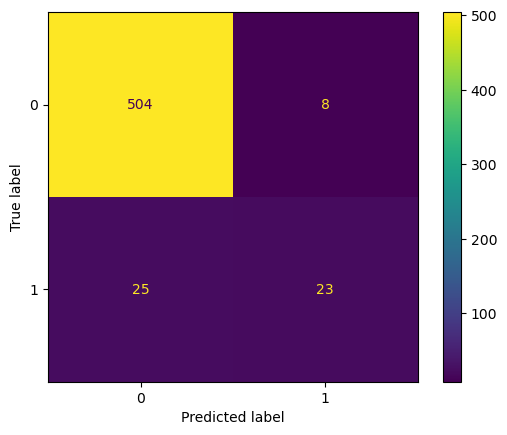

In [26]:
### CONFUSION MATRIX

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_stratified
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv)
plt.show()


#### With autoregression

In [27]:
### TRAINING

params = {}

labeled = eumf_pipeline.prepare_data(panel_comb_3m_macro, columns=["19", "value", "gdp", "unempl"])
transformed = eumf_pipeline.transform_data(labeled)

# stacked = stack_data(transformed)
# data_cls = discretize_labels(stacked)

train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN_TWOCLS, t_test_max=T_TEST_MAX_TWOCLS
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=BINS_TWOCLS, classes=[0, 1]
)

# train_stacked = stack_data(transformed)
# train_cls = discretize_labels(train_stacked, bins=bins, classes=classes)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params, cv=cv_stratified)

display(pd.DataFrame(tuner.cv_results_))


cv_score = eumf_eval.score_cv(
    tuner.best_estimator_,
    train_cls.x,
    train_cls.y,
    cv=cv_stratified,
    scoring=SCORING_TWOCLS,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls.x, test_cls.y, scoring=SCORING_TWOCLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.341,0.009,0.031,0.006,{},0.903,0.912,0.853,0.894,0.733,0.894,0.865,0.062,1


Aggregate CV score:


,mean,std,sem
fit_time,0.135,0.039,0.016
score_time,0.030,0.004,0.002
test_roc_auc,0.955,0.043,0.018
test_average_precision,0.827,0.104,0.043
test_f1,0.750,0.128,0.052
test_precision,0.855,0.114,0.047
test_recall,0.688,0.174,0.071
test_f1_macro,0.865,0.068,0.028


Individual CV scores:


,fit_time,score_time,test_roc_auc,test_average_precision,test_f1,test_precision,test_recall,test_f1_macro
0,0.212,0.032,0.961,0.840,0.824,1.000,0.700,0.903
1,0.122,0.034,0.920,0.789,0.842,0.800,0.889,0.912
2,0.132,0.032,0.984,0.874,0.737,0.778,0.700,0.853
3,0.117,0.026,0.995,0.943,0.800,0.800,0.800,0.894
4,0.107,0.025,0.885,0.641,0.500,0.750,0.375,0.733
5,0.119,0.027,0.983,0.877,0.800,1.000,0.667,0.894


Holdout score:


roc_auc              0.927
average_precision    0.771
f1                   0.500
precision            0.833
recall               0.357
f1_macro             0.714
dtype: float64

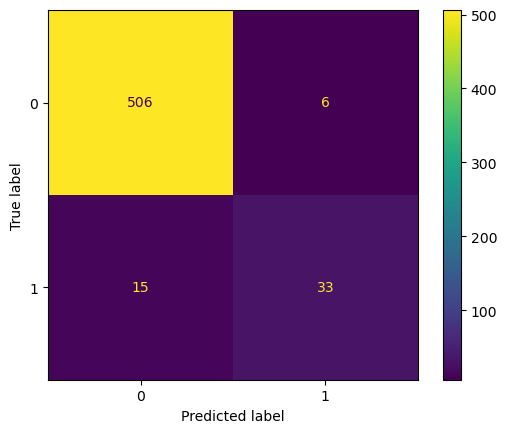

In [28]:
### CONFUSION MATRIX

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_stratified
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv)
plt.show()


These results are even better. But is it worth to pay the price?

#### Everything without trends

In [29]:
### TRAINING

params = {}

labeled = eumf_pipeline.prepare_data(panel_comb_3m_macro, columns=["value", "gdp", "unempl"])
transformed = eumf_pipeline.transform_data(labeled)

# stacked = stack_data(transformed)
# data_cls = discretize_labels(stacked)

train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN_TWOCLS, t_test_max=T_TEST_MAX_TWOCLS
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=BINS_TWOCLS, classes=[0, 1]
)

# train_stacked = stack_data(transformed)
# train_cls = discretize_labels(train_stacked, bins=bins, classes=classes)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params, cv=cv_stratified)

display(pd.DataFrame(tuner.cv_results_))


cv_score = eumf_eval.score_cv(
    tuner.best_estimator_,
    train_cls.x,
    train_cls.y,
    cv=cv_stratified,
    scoring=SCORING_TWOCLS,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls.x, test_cls.y, scoring=SCORING_TWOCLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.265,0.008,0.032,0.004,{},0.903,0.939,0.888,0.894,0.662,0.855,0.857,0.091,1


Aggregate CV score:


,mean,std,sem
fit_time,0.114,0.021,8.493e-03
score_time,0.027,0.002,7.487e-04
test_roc_auc,0.956,0.046,1.886e-02
test_average_precision,0.816,0.133,5.449e-02
test_f1,0.734,0.189,7.701e-02
test_precision,0.826,0.111,4.533e-02
test_recall,0.684,0.227,9.270e-02
test_f1_macro,0.857,0.099,4.050e-02


Individual CV scores:


,fit_time,score_time,test_roc_auc,test_average_precision,test_f1,test_precision,test_recall,test_f1_macro
0,0.155,0.030,0.971,0.858,0.824,1.000,0.700,0.903
1,0.112,0.026,0.920,0.817,0.889,0.889,0.889,0.939
2,0.105,0.028,0.992,0.931,0.800,0.800,0.800,0.888
3,0.102,0.026,0.993,0.903,0.800,0.800,0.800,0.894
4,0.101,0.025,0.879,0.559,0.364,0.667,0.250,0.662
5,0.105,0.027,0.978,0.831,0.727,0.800,0.667,0.855


Holdout score:


roc_auc              0.915
average_precision    0.797
f1                   0.421
precision            0.800
recall               0.286
f1_macro             0.672
dtype: float64

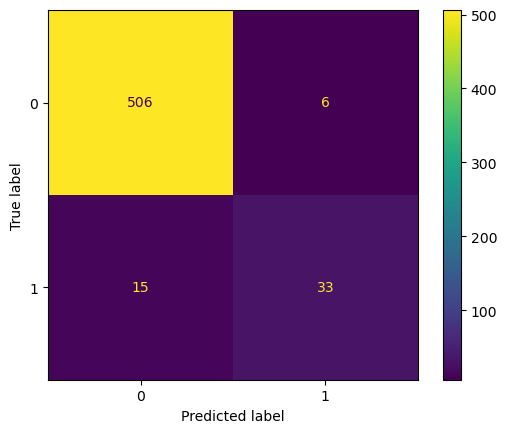

In [30]:
### CONFUSION MATRIX

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_stratified
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv)
plt.show()


No benefit by GT anymore. Sad. However, GT can be treated as substitute for autoregressive lags if these are not warranted. 